In [104]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

In [105]:
X, y = make_moons(n_samples=1000, random_state=42)

In [106]:
X.shape

(1000, 2)

In [107]:
y.shape

(1000,)

In [108]:
y = y.reshape(-1, 1)

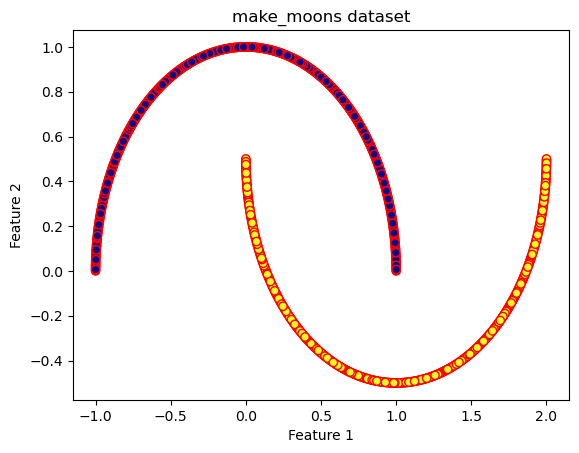

In [109]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='plasma', edgecolor='r')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('make_moons dataset')
plt.show()

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [111]:
device = torch.device('mps' if torch.mps.is_available else 'cpu')
device

device(type='mps')

In [112]:
X_train = torch.tensor(X_train, dtype=torch.float).to(device)
X_test  = torch.tensor(X_test, dtype=torch.float).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device)
y_test  = torch.tensor(y_test, dtype=torch.float).to(device)

In [113]:
class NeuralNetwork(nn.Module):
    def __init__(self, input):
        super().__init__()
        self.layer1 = nn.Linear(in_features=input, out_features=64)
        self.layer2 = nn.Linear(in_features=64, out_features=32)
        self.layer3 = nn.Linear(in_features=32, out_features=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)

        x = self.relu(self.layer2(x))
        x = self.dropout(x)

        x = self.sigmoid(self.layer3(x))
        return x

In [114]:
input = X.shape[1]
input

2

In [115]:
model = NeuralNetwork(input).to(device)
model

NeuralNetwork(
  (layer1): Linear(in_features=2, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.3, inplace=False)
)

In [116]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [117]:
torch.manual_seed(42)

epoch_size, train_loss_l, test_loss_l, train_acc_l, test_acc_l = [], [], [], [], []

epochs = 1000

for epoch in range(epochs):
    model.train()
    train_pred = model(X_train)
    train_loss = criterion(train_pred, y_train).squeeze()
    train_acc = accuracy_score(y_train.cpu(), (train_pred > 0.5).int().cpu())
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test)
        test_loss = criterion(test_pred, y_test).squeeze()
        test_acc  = accuracy_score(y_test.cpu(), (test_pred > 0.5).int().cpu())

    if epoch % 20 == 0:
        train_loss_l.append(train_loss.item())
        test_loss_l.append(test_loss.item())
        train_acc_l.append(train_acc)
        test_acc_l.append(test_acc)
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")


Epoch 000 | Train Loss: 0.6946 | Train Acc: 0.5088 | Test Loss: 0.6329 | Test Acc: 0.8150
Epoch 020 | Train Loss: 0.1896 | Train Acc: 0.9125 | Test Loss: 0.1417 | Test Acc: 0.9400
Epoch 040 | Train Loss: 0.0626 | Train Acc: 0.9800 | Test Loss: 0.0270 | Test Acc: 1.0000
Epoch 060 | Train Loss: 0.0154 | Train Acc: 0.9975 | Test Loss: 0.0042 | Test Acc: 1.0000
Epoch 080 | Train Loss: 0.0051 | Train Acc: 0.9988 | Test Loss: 0.0012 | Test Acc: 1.0000
Epoch 100 | Train Loss: 0.0072 | Train Acc: 1.0000 | Test Loss: 0.0010 | Test Acc: 1.0000
Epoch 120 | Train Loss: 0.0031 | Train Acc: 1.0000 | Test Loss: 0.0007 | Test Acc: 1.0000
Epoch 140 | Train Loss: 0.0034 | Train Acc: 1.0000 | Test Loss: 0.0006 | Test Acc: 1.0000
Epoch 160 | Train Loss: 0.0018 | Train Acc: 1.0000 | Test Loss: 0.0003 | Test Acc: 1.0000
Epoch 180 | Train Loss: 0.0022 | Train Acc: 1.0000 | Test Loss: 0.0001 | Test Acc: 1.0000
Epoch 200 | Train Loss: 0.0022 | Train Acc: 1.0000 | Test Loss: 0.0002 | Test Acc: 1.0000
Epoch 220 

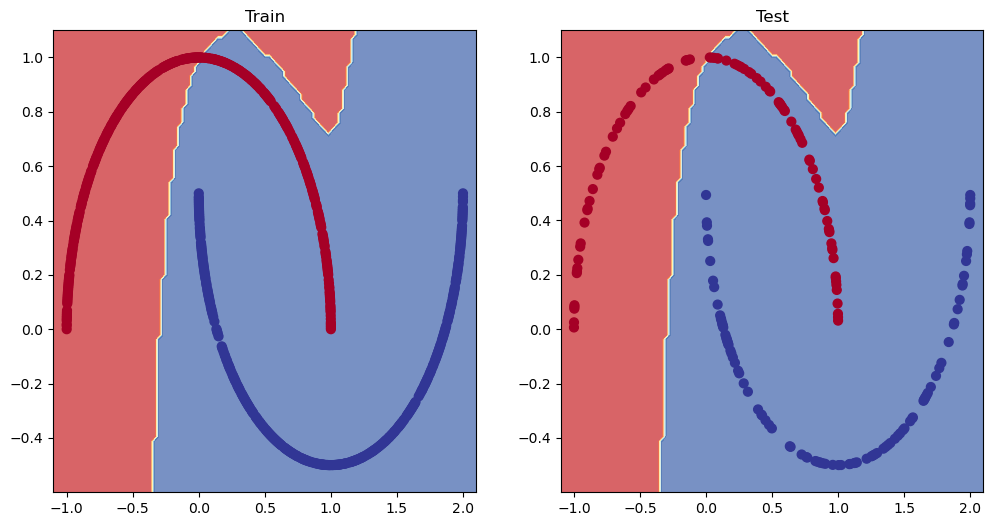

In [118]:
from helper_functions import plot_decision_boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model, X_test, y_test)